# Sheet 03

In [1]:
import numpy as np
import cv2 as cv
import random
from matplotlib import pyplot as plt

## 1. Hough Transform

Read the image shapes.png.

(a) Detect the lines by a Hough transform using cv2.HoughLines. Visualize the detections by drawing lines on the image.

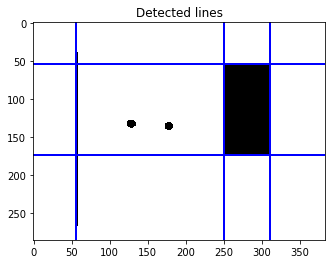

In [2]:
img = cv.imread('./images/shapes.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 80)

lines = cv.HoughLines(edges, 1, np.pi/90, 50)
for line in lines:
    d, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*d
    y0 = b*d
    x1 = int(x0 + np.linalg.norm(img.shape)*(-b))
    y1 = int(y0 + np.linalg.norm(img.shape)*a)
    x2 = int(x0 - np.linalg.norm(img.shape)*(-b))
    y2 = int(y0 - np.linalg.norm(img.shape)*a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

#cv.imshow('Detected lines', img)
#cv.waitKey(0)
#cv.destroyAllWindows()
_ = plt.imshow(img)
_ = plt.title('Detected lines')

(b) Implement the function myHoughLines and use it to detect the lines. Visualize the detections and the accumulator.

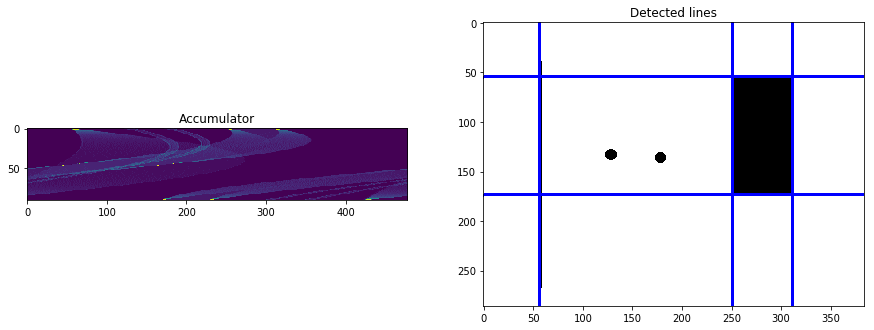

In [3]:
def myHoughLines(img_edges, d_resolution, theta_step_sz, threshold):
    """
    Your implementation of HoughLines
    :param img_edges: single-channel binary source image (e.g: edges)
    :param d_resolution: the resolution for the distance parameter
    :param theta_step_sz: the resolution for the angle parameter
    :param threshold: minimum number of votes to consider a detection
    :return: list of detected lines as (d, theta) pairs and the accumulator
    """
    accumulator = np.zeros((int(180/theta_step_sz), int(np.linalg.norm(img_edges.shape)/d_resolution)))
    edges_points = np.array(np.nonzero(img_edges))

    for i in range(edges_points.shape[1]):
        for theta in range(0, 180, theta_step_sz):
            d = int((edges_points[1][i] * np.cos(theta*np.pi/180.) + edges_points[0][i] * np.sin(theta*np.pi/180.)) / d_resolution)
            accumulator[int(theta/theta_step_sz), d] += 1
        
    accumulator_copy = accumulator
    detected_lines = []
    finished = False
    while not finished:
        idx = np.argmax(accumulator_copy)
        theta, d = np.unravel_index(idx, accumulator_copy.shape)

        if accumulator_copy[theta, d] > threshold:
            detected_lines.append([d * d_resolution, theta * theta_step_sz * np.pi / 180.])
        else:
            finished = True

        accumulator_copy[theta, d] = 0

    return detected_lines, accumulator


img = cv.imread('./images/shapes.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 80)

detected_lines, accumulator = myHoughLines(edges, 1, 2, 50)

for line in detected_lines:
    d, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*d
    y0 = b*d
    x1 = int(x0 + np.linalg.norm(img.shape)*(-b))
    y1 = int(y0 + np.linalg.norm(img.shape)*a)
    x2 = int(x0 - np.linalg.norm(img.shape)*(-b))
    y2 = int(y0 - np.linalg.norm(img.shape)*a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

accumulator = 255*(accumulator-np.min(accumulator))/float(np.max(accumulator)-np.min(accumulator))
accumulator = np.uint8(np.round(accumulator))
#cv.imshow('Accumulator', acc)
#cv.waitKey(0)
#cv.imshow('Detected lines', img)
#cv.waitKey(0)
#cv.destroyAllWindows()
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
_ = plt.imshow(accumulator)
_ = plt.title('Accumulator')
plt.subplot(1,2,2)
_ = plt.imshow(img)
_ = plt.title('Detected lines')

## Mean Shift
Read the image line.png and use your implementation of myHoughLines to get
the accumulator of the detected lines in the image. Then implement the mean shift
algorithm to find the peaks in the accumulator. Visualize the accumulator and the
lines corresponding to the peaks.

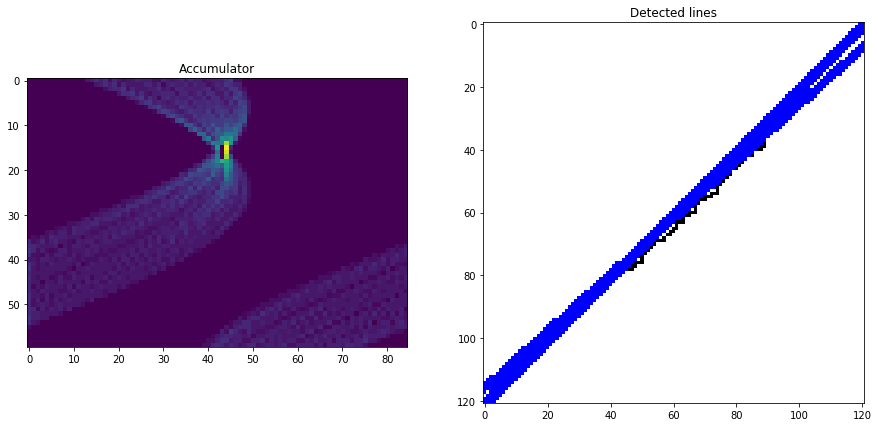

In [5]:
img = cv.imread('./images/line.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 50)
theta_res = 3
d_res = 2
threshold = 6*50
_, accumulator = myHoughLines(edges, d_res, theta_res, 50)

window = 9
var = 9
peaks = []
for i in range(accumulator.shape[0]):
    for j in range(accumulator.shape[1]):

        if accumulator[i, j] == 0:
            continue
        y1 = i
        x1 = j
        conveged = False
        while not conveged:
            sum_w = 0
            sum_x = 0
            sum_y = 0

            for x in range(int(max(x1-window, 0)), int(min(x1 + window, accumulator.shape[1] - 1))):
                for y in range(int(max(y1-window, 0)), int(min(y1+window, accumulator.shape[0] - 1))):
                    if np.linalg.norm([x - x1, y - y1]) < window:
                        w = np.exp(-(np.linalg.norm([x - x1, y - y1])**2) / (2.*var))
                        sum_w += w * accumulator[y, x]
                        sum_x += x * w * accumulator[y, x]
                        sum_y += y * w * accumulator[y, x]

            x2 = sum_x / sum_w
            y2 = sum_y / sum_w
            if np.linalg.norm([x2 - x1, y2 - y1]) < 0.05:
                conveged = True
            else:
                x1 = x2
                y1 = y2
        if [int(round(x2)), int(round(y2))] not in peaks:
            if sum_w > threshold:
                peaks.append([int(round(x2)), int(round(y2))])

for line in peaks:
    d, theta = line
    theta = theta * theta_res * np.pi / 180.
    d = d * d_res
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * d
    y0 = b * d
    x1 = int(x0 + np.linalg.norm(img.shape) * (-b))
    y1 = int(y0 + np.linalg.norm(img.shape) * a)
    x2 = int(x0 - np.linalg.norm(img.shape) * (-b))
    y2 = int(y0 - np.linalg.norm(img.shape) * a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

acc = 255 * (accumulator - np.min(accumulator)) / float(np.max(accumulator) - np.min(accumulator))
acc = np.uint8(np.round(acc))
#cv.imshow('Accumulator', acc)
#cv.waitKey(0)
#cv.imshow('Detected lines', img)
#cv.waitKey(0)
#cv.destroyAllWindows()
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
_ = plt.imshow(accumulator)
_ = plt.title('Accumulator')
plt.subplot(1,2,2)
_ = plt.imshow(img)
_ = plt.title('Detected lines')

## K-Means
Implement the function myKmeans and then use it to segment the image flower.png
based on:

(a) Intensity

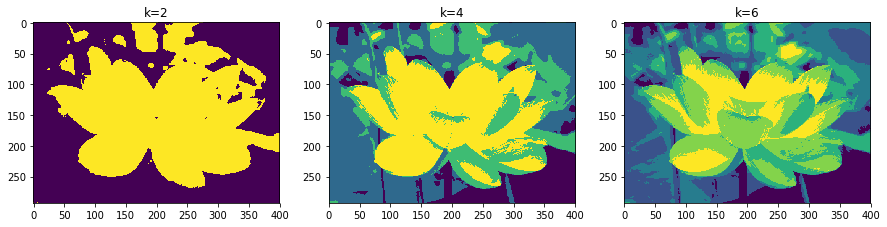

In [6]:
def myKmeans(data, k):
    """
    Your implementation of k-means algorithm
    :param data: list of data points to cluster
    :param k: number of clusters
    :return: centers and list of indices that store the cluster index for each data point
    """
    centers = np.zeros((k, data.shape[1]))
    index = np.zeros(data.shape[0], dtype=int)
    clusters = [[] for i in range(k)]

    # random centers initialization
    for i in range(k):
        centers[i] = data[random.randint(0, data.shape[0] - 1)]

    convergence = False
    while not convergence:
        convergence = True
        for i in range(k):
            clusters[i] = []

        # assign each point to the cluster of closest center
        for i in range(data.shape[0]):
            min_dist = np.inf
            closest_center = 0
            for j in range(k):
                dist = np.linalg.norm(data[i] - centers[j])
                if dist < min_dist:
                    min_dist = dist
                    closest_center = j
            clusters[closest_center].append(data[i])
            index[i] = closest_center
        # update clusters' centers
        for i in range(k):
            if len(clusters[i]) != 0:
                c = sum(clusters[i]) / float(len(clusters[i]))
                if np.linalg.norm(c - centers[i]) > 2:
                    convergence = False
                centers[i] = c

    return index, centers


img = cv.imread('./images/flower.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

data = img_gray.reshape((-1, 1))
data = np.float32(data)
plt.figure(figsize=(15,15))
i = 1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img_gray.shape))

    #cv.imshow('kmeans based on intensity, k='+str(k), res2)
    #cv.waitKey(0)
    #cv.destroyAllWindows()
    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

(b) Color

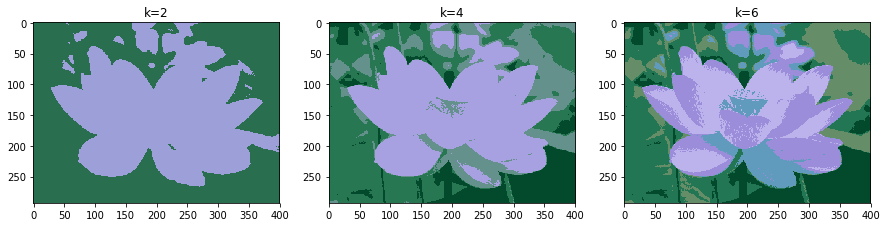

In [7]:
img = cv.imread('./images/flower.png')

data = img.reshape((-1, 3))
data = np.float32(data)
plt.figure(figsize=(15,15))
i=1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    #cv.imshow('kmeans based on color, k='+str(k), res2)
    #cv.waitKey(0)
    #cv.destroyAllWindows()
    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

(c) Intensity and (properly scaled) image position

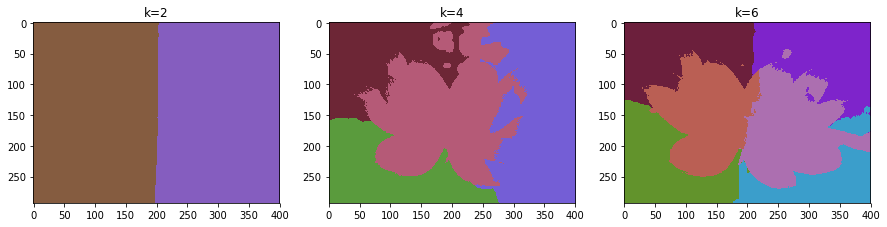

In [8]:
img = cv.imread('./images/flower.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

pos = np.indices(img_gray.shape).transpose(1, 2, 0).reshape(-1, 2)
pos = np.float32(pos * 255. / np.max(pos))

data = img_gray.reshape((-1, 1))
data = np.float32(data)
data = np.concatenate((data, pos), axis=1)
plt.figure(figsize=(15,15))
i=1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    #cv.imshow('kmeans based on intensity and position, k='+str(k), res2)
    #cv.waitKey(0)
    #cv.destroyAllWindows()
    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

## Graph Cuts
Consider the graph shown in Figure 1 to answer the following questions:

![title](graph_2.png)

(a) Compute the eigenvector y corresponding to the second smallest eigenvalue of
the following generalized eigenvalue problem

(D − W )y = λDy

where W is the affinity matrix of the graph and D is a diagonal matrix that
contains the degrees of the vertices.

Hint: use cv2.eigen to solve the equivalent standard eigenvalue problem


D^(-1/2) (D − W )D^(-1/2) z = λz ;      z = D^(1/2) y

In [11]:
D = [[2.2,   0,   0,   0,   0,   0,   0,   0],
     [  0, 2.1,   0,   0,   0,   0,   0,   0],
     [  0,   0, 2.6,   0,   0,   0,   0,   0],
     [  0,   0,   0,   3,   0,   0,   0,   0],
     [  0,   0,   0,   0,   3,   0,   0,   0],
     [  0,   0,   0,   0,   0,   3,   0,   0],
     [  0,   0,   0,   0,   0,   0, 3.3,   0],
     [  0,   0,   0,   0,   0,   0,   0,   2]
    ]
W = [[ 0,  1, .2,  1,  0,  0,  0,  0],
     [ 1,  0, .1,  0,  1,  0,  0,  0],
     [.2, .1,  0,  1,  0,  1, .3,  0],
     [ 1,  0,  1,  0,  0,  1,  0,  0],
     [ 0,  1,  0,  0,  0,  0,  1,  1],
     [ 0,  0,  1,  1,  0,  0,  1,  0],
     [ 0,  0, .3,  0,  1,  1,  0,  1],
     [ 0,  0,  0,  0,  1,  0,  1,  0]
    ]

D = np.array(D, dtype=float)
W = np.array(W, dtype=float)

d_inv_sqrt = np.linalg.inv(np.sqrt(D))

A = np.matmul(d_inv_sqrt, (D-W))
A = np.matmul(A, d_inv_sqrt)

_, e, z = cv.eigen(A)

y = np.matmul(d_inv_sqrt, z)
print (y[-2])

[-0.13209535  0.0503975  -0.19504592 -0.24930618  0.26130075 -0.14527607
  0.17010498  0.25401931]


(b) Use the result of part (a) to find the minimum normalized cut NCut(C 1 , C 2 ).
The sign of the values in the eigenvector computed in (a) determine the separa-
tion of the vertices into the two clusters C 1 , C 2 . List the nodes in each cluster
and compute the cost of the normalized cut.

In [10]:
print(y[-2] > 0)

[False  True False False  True False  True  True]


C1 = {A, C, D, F}

C2 = {B, E, G, H}

NCut(C1, C2) = 2.4 * (1/(2.2 + 2.6 + 3 + 3) + 1/(2.1 + 3 + 3.3 + 2)) = 0.4529